In [8]:
#commented uncessary print statements
#defined functions in order to use numba pre compiler
#coverted some unecessary matrices to scalras inorder to conserve memory (eg. random numbers)

#ain to comapre with the MATLAB code

In [9]:
#importing the required libraries

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import cProfile
from numba import jit

In [10]:
#opening a file to store data
f = open("epid_time_series.txt","w+") 

In [11]:
#making the nodes interact and hence transfering doses

def interaction(N,k,indi_state,d,p,partner):
    for n in range(0,N): #loop for nodes
#         print('n = ',n)
        partner[n,k] = np.random.randint(0,N)
#         print(partner[n,k])
        z1 = np.random.uniform()

        #if one is susceptible and the other is infected and they are connected 
        if (indi_state[n,k-1] == 1) and (indi_state[partner[n,k],k-1] == 2) :
            if p >= z1 :
#                 print('postive dose to the one')
                d[n,k] = 1 #the one receives constant dose
#                 d[partner[n,k],k] = 0 #the other receives no dose
            else :
#                 'interaction but no dose'
                d[n,k] = 0
#                 d[partner[n,k],k] = 0
        #if both are infected and they are connected
        elif (indi_state[n,k-1] == 2) and (indi_state[partner[n,k],k-1] == 2) :
            if p >= z1 :
#                 'postive dose for both'
                d[n,k] = 1 #the other receives constant dose
#                 d[partner[n,k],k] = 0 #the one STILL receives NO DOSE
            else :
#                 'interaction but no dose'
                d[n,k] = 0
#                 d[partner[n,k],k] = 0
        else :
#             'no interaction at all'
                d[n,k] = 0
#                 d[partner[n,k],k] = 0
    return d

In [12]:
#updating the cumulative dose distribution

def upd_cumu(k,mem_time_steps,d,d_ini,D) :
    #     updating cumulative dose
    D[:,k] = 0
    m = k - (mem_time_steps)
    if m > 0 :
        D[:,k] = np.sum(d[:,m:k+1:1],1)
    if m <= 0 :
        while m <= 0 :
            m = m + 1
#     print('m=',m)
        D[:,k] = np.sum(d[:,m:k+1:1],1) + np.sum(d_ini[:,0:((mem_time_steps-(k-m))):1],1)
#         print(np.sum(d[:,m:k+1:1],1))
#         print(np.sum(d_ini[:,0:((mem_time_steps-(k-m))):1],1))
#     print(((mem_time_steps-(k-m)))+1)
#     print(np.sum(d_ini[:,0:((mem_time_steps-(k-m))):1],1))

#     print(D)
    return D

In [13]:
def upd_indi_state(k,N,D,d_star,indi_state,phi,rho,r) :
    for n in range(0,N):
#         if threshold is met and is susceptible
        if (D[n,k] >= d_star[n,0]) and (indi_state[n,k-1] == 1) :
#             'above thresh becomes infected'
            indi_state[n,k] = 2 #susceptible becomes infected
        elif (D[n,k] < d_star[n,0]) and (indi_state[n,k-1] == 2) :
#         recovery : if drops bel threshold and is infected
            z2 = np.random.uniform()
            if r >= z2 :
#                 'below thresh'
                z3 = np.random.uniform()
                if rho >= z3 :
#                     'below thresh becomes susceptible'
                    indi_state[n,k] = 1
                else :
#                     'below thresh becomes immune'
                    indi_state[n,k] = 3
            else :
#                 'below thresh stays infected'
                indi_state[n,k] = 2
        else :
#             'retains previous state'
            indi_state[n,k] = indi_state[n,k-1]

#     phi[0,k] = np.count_nonzero(indi_state[:,k] == 2)/N
    return phi,indi_state

In [14]:
#user controlled variables

for p in range(0,11) :
    p = p*0.1
    print("p=",p)
    for start in range(0,11) :
        start = start*0.1
        print("start=",start)
        rho = 1   #probability of becoming susceptible after recovery
        r = 0.5    #probability of recovery when dose level drops below threshold

        N = 100   #number of individuals
        T = 1000  #number of time steps

        mem_time_steps = 2 #the number of previous time steps which the individual remembers about 

        d_star = 1.*np.ones((N,1),dtype=np.int32)

        #initialising variables and arrays to store information

        phi = 999*np.ones([1,T]) #fraction of steady state infected


        t = np.arange(0,T) #time steps
        t = np.asarray(t).reshape(1,T)

        partner = 999*np.ones((N,T),dtype=np.int32) #partners used to form pairs in every time step
        partner = np.asarray(partner)

        indi_state = np.zeros((N,T),dtype=np.int32) #stores the state of eahc individual
        indi_state[:,0] = 1

        d_ini = np.zeros((N,mem_time_steps))
        d = 999*np.ones((N,T)) #doses
        D = 999*np.ones((N,T)) #cumulative doses

        
        #initial state of individuals
        #randomly grouping into i, s or r

        infec = random.sample(range(0, N), np.int32(start*N)) #radnomly infecting few individuals as initial condition
        # np.random.shuffle(infec)
        infec = np.asarray(infec).reshape(np.int32(start*N),1)
#         print(start*N)
        if start != 0 :
            indi_state[infec[:,0],0] = 2

        phi[0,0] = np.count_nonzero(indi_state[:,0] == 2)/N
        
        #implementing marc's initial condition
        I = np.where(indi_state[:,0]==2)
        I = np.transpose(np.asarray(I))

        if len(I) != 0 :
            for i in range(0,len(I)) : 
                dose_slots = np.random.choice(mem_time_steps,size=2,replace=False)
                for j in range(0,len(dose_slots)) :
                    d_ini[I[i],dose_slots[j]] = 1
        else :
            d_ini[:,0:] = 0

#         #implementing marc's initial condition
#         I = np.where(indi_state[:,0]==2)
#         I = np.transpose(np.asarray(I))
        
#         if len(I) != 0 :
#             for i in range(0,len(I)) : 
#                 d_ini[I[i],0:] = p
#         else :
#             d_ini[:,0:] = 0
        
#         print(d_ini)

        for k in range(1,T): #loop for time
#             print(d)
            d = interaction(N,k,indi_state,d,p,partner) #calling the interaction function
#             print('indi_state=\n',indi_state)
#             print('d=\n',d)
            D = upd_cumu(k,mem_time_steps,d,d_ini,D) #calling the fucntions to obtain and update cumulative dose
#             print('D=\n',D)
            phi,indi_state = upd_indi_state(k,N,D,d_star,indi_state,phi,rho,r) #calling the function to update the state of the nodes
            
            phi[0,k] = np.count_nonzero(indi_state[:,k] == 2)/N
            f.write("%f\t" % (phi[0,k]))
            f.flush()
        f.write("\n")
        
#         phi_star = sum(phi[0,k-100:k])/100 #obtaining average phi_star of the last 100 time steps
#         print("phi_star=", phi_star)
        
#         f.write("%f\t%f\t%f\n" % (p,start,phi_star))
#         f.flush()
            

p= 0.0
start= 0.0
start= 0.1
start= 0.2
start= 0.30000000000000004
start= 0.4
start= 0.5
start= 0.6000000000000001
start= 0.7000000000000001
start= 0.8
start= 0.9
start= 1.0
p= 0.1
start= 0.0
start= 0.1
start= 0.2
start= 0.30000000000000004
start= 0.4
start= 0.5
start= 0.6000000000000001
start= 0.7000000000000001
start= 0.8
start= 0.9
start= 1.0
p= 0.2
start= 0.0
start= 0.1
start= 0.2
start= 0.30000000000000004
start= 0.4
start= 0.5
start= 0.6000000000000001
start= 0.7000000000000001
start= 0.8
start= 0.9
start= 1.0
p= 0.30000000000000004
start= 0.0
start= 0.1
start= 0.2
start= 0.30000000000000004
start= 0.4
start= 0.5
start= 0.6000000000000001
start= 0.7000000000000001
start= 0.8
start= 0.9
start= 1.0
p= 0.4
start= 0.0
start= 0.1
start= 0.2
start= 0.30000000000000004
start= 0.4
start= 0.5
start= 0.6000000000000001
start= 0.7000000000000001
start= 0.8
start= 0.9
start= 1.0
p= 0.5
start= 0.0
start= 0.1
start= 0.2
start= 0.30000000000000004
start= 0.4
start= 0.5
start= 0.6000000000000001

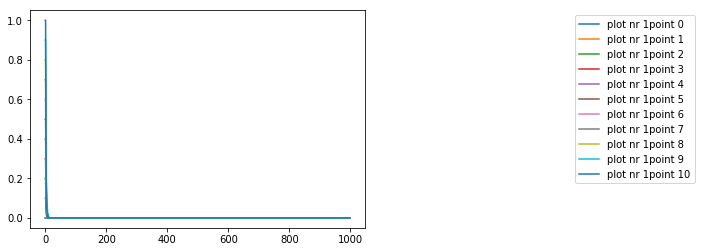

In [15]:
'''time series plot'''

for i in range(0,11) :
#     print(i,T)
    nr=(i)%121
    a = np.loadtxt("epid_time_series.txt")[i,:]
    plt.plot(a,label='plot nr %i'%(int(i/121)+1)+"point %i"%nr)
#     plt.plot(a)
    plt.legend(bbox_to_anchor=(2,1))
#     plt.axhline(y=0.6)
#     plt.axhline(y=0.4)

#     k = 1000
#     phi_star = sum(a[0,k-100:k])/100 #obtaining average phi_star of the last 100 time steps
#     print("phi_star=",phi_star)

In [16]:
'''averaging from time series'''

f = open("epid_phi_star_data.txt","w+") 
k = 1000
# phi_star = sum(a[counter,k-100:k])/100 #obtaining average phi_star of the last 100 time steps
# print("phi_star=",phi_star)

counter = 0
for p in range(0,11):
    p = p*0.1
    print(p)
    for start in range(0,11):
        start = start*0.1
        a = np.loadtxt("epid_time_series.txt")[counter,:]
        phi_star = np.average(a[k-100:k])
        f.write("%f\t%f\t%f\n" % (p,start,phi_star))
        f.flush()
        counter = counter + 1
print(counter)

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
121


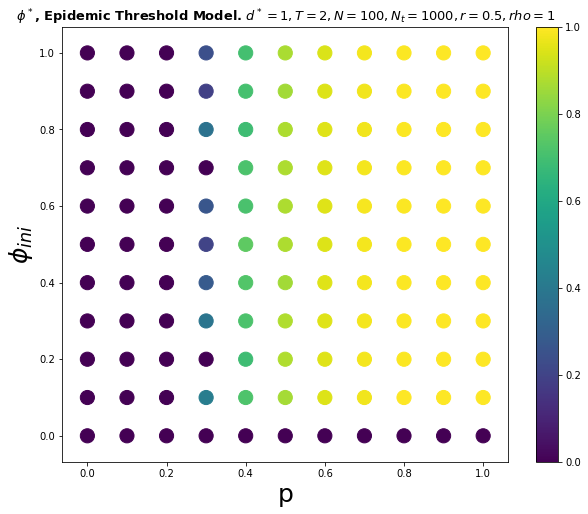

In [17]:
a = np.loadtxt("epid_phi_star_data.txt")[:,0]
b =  np.loadtxt("epid_phi_star_data.txt")[:,1]
c =  np.loadtxt("epid_phi_star_data.txt")[:,2]


plt.figure(figsize=(10,8))
plt.scatter(a, b, c=c,s=200)
plt.colorbar()
# plt.title(r'$\phi^*$, Critical Threshold Model. $d^*=3,T=12, N=100,N_t=1000,r=1,rho=1$',fontsize=15,fontweight='bold')
plt.title(r'$\phi^*$, Epidemic Threshold Model. $d^*=1,T=2, N=100,N_t=1000,r=0.5,rho=1$',fontsize=13,fontweight='bold')
plt.xlabel('p',fontsize=25)
plt.xlabel('p',fontsize=25)
plt.ylabel(r'$\phi_{ini}$',fontsize=25)
plt.savefig("epidemic_colourmap_ini_p_blah.svg", format="svg")
plt.show()

In [18]:
def someloop(q,l) :
    q[1,l] = 10

    return q

In [19]:
q = np.ones((3,4))

for l in range(0,2) : 
    print(q)
    someloop(q,l)
    print(q)

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[[ 1.  1.  1.  1.]
 [10.  1.  1.  1.]
 [ 1.  1.  1.  1.]]
[[ 1.  1.  1.  1.]
 [10.  1.  1.  1.]
 [ 1.  1.  1.  1.]]
[[ 1.  1.  1.  1.]
 [10. 10.  1.  1.]
 [ 1.  1.  1.  1.]]
